In [1]:
import pandas as pd 
import numpy as np
from snowflake.snowpark import Session
import snowflake.snowpark.functions as sfunc
import snowflake.snowpark.types as stypes
import plotly.graph_objects as go
from IPython.display import Image as IPImage

from config import SNOWFLAKE_USER, SNOWFLAKE_PASSWORD

In [2]:
connection_parameters = {
    "user": SNOWFLAKE_USER,
    "password": SNOWFLAKE_PASSWORD,
    "account": "pca67849",
    "warehouse": "WH_4_XS",
    "database": "TEMPORARY_DATA",
    "schema": "MBONE",
}
    
session = Session.builder.configs(connection_parameters).create()

genai_skills = [
    "ChatGPT", "Expert System", "IBM Watson", "IPSoft Amelia", "Ithink", "Virtual Agents", 
    "Artificial Intelligence",
    # added
    "Generative Artificial Intelligence"
]
auto_drive_skills = ["Autonomous Systems", "Lidar", "OpenCV", "Path Planning", "Remote Sensing"]
nlp_skills = [
    "ANTLR", "Automatic Speech Recognition (ASR)", "Chatbot", "Computational Linguistics", 
    "Distinguo", "Latent Dirichlet Allocation", "Latent Semantic Analysis", "Lexalytics", 
    "Lexical Acquisition", "Lexical Semantics", "Machine Translation (MT)", 
    "Modular Audio Recognition Framework (MARF)", "MoSes", "Natural Language Processing", 
    "Natural Language Toolkit (NLTK)", "Nearest Neighbour Algorithm", "OpenNLP", 
    "Sentiment Analysis/Opinion Mining", "Speech Recognition", "Text Mining", 
    "Text to Speech (TTS)", "Tokenization", "Word2Vec"
]
neural_network_skills = [
    "Caffe Deep Learning Framework", "Convolutional Neural Network (CNN)", "Deep Learning",
    "Deeplearning4j", "Keras", "Long Short-Term Memory (LSTM)", "MXNet", "Neural Networks",
    "Pybrain", "Recurrent Neural Network (RNN)", "TensorFlow"
]
ml_skills = [
    "AdaBoost algorithm", "Boosting (Machine Learning)", "Chi Square Automatic Interaction Detection (CHAID)",
    "Classification Algorithms", "Clustering Algorithms", "Decision Trees", "Dimensionality Reduction", 
    "Google Cloud Machine Learning Platform", "Gradient boosting", "H2O (software)", "Libsvm", 
    "Machine Learning", "Madlib", "Mahout", "Microsoft Cognitive Toolkit", "MLPACK (C++ library)", 
    "Mlpy", "Random Forests", "Recommender Systems", "Scikit-learn", "Semi-Supervised Learning", 
    "Supervised Learning (Machine Learning)", "Support Vector Machines (SVM)", 
    "Semantic Driven Subtractive Clustering Method (SDSCM)", "Torch (Machine Learning)", 
    "Unsupervised Learning", "Vowpal", "Xgboost"
]
robotics_skills = [
    "Blue Prism", "Electromechanical Systems", "Motion Planning", "Motoman Robot Programming", 
    "Robot Framework", "Robotic Systems", "Robot Operating System (ROS)", "Robot Programming", 
    "Servo Drives/Motors", "Simultaneous Localization and Mapping (SLAM)"
]
vision_skills = [
    "Computer Vision", "Image Processing", "Image Recognition", "Machine Vision", "Object Recognition"
]

all_ai_skills = genai_skills + auto_drive_skills + nlp_skills + neural_network_skills + ml_skills + robotics_skills + vision_skills

# Preparing Postings Data

In [55]:
us_posts_df = session.read.table("OII_US_10M_SAMP_POSTS")
us_skills_df = session.read.table("OII_US_10M_SAMP_SKILLS")
uk_posts_df = session.read.table("OII_UK_10M_SAMP_POSTS")
uk_skills_df = session.read.table("OII_UK_10M_SAMP_SKILLS")

us_total_posts_df = us_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), sfunc.quarter("POSTED").alias("QUARTER")) \
    .group_by(["YEAR", "QUARTER"]).count().order_by(["YEAR", "QUARTER"])
    
uk_total_posts_df = uk_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), sfunc.quarter("POSTED").alias("QUARTER")) \
    .group_by(["YEAR", "QUARTER"]).count().order_by(["YEAR", "QUARTER"])

us_ai_ids = us_posts_df \
    .join(us_skills_df, us_posts_df["ID"] == us_skills_df["ID"]) \
    .filter(us_skills_df["SKILL_NAME"].isin(all_ai_skills)) \
    .select(us_posts_df["ID"].alias("ID"))
        
us_ai_posts_df = us_posts_df \
    .filter(us_posts_df["ID"].isin(us_ai_ids))
    
us_nonai_posts_df = us_posts_df \
    .filter(~us_posts_df["ID"].isin(us_ai_ids))
    
uk_ai_ids = uk_posts_df \
    .join(uk_skills_df, uk_posts_df["ID"] == uk_skills_df["ID"]) \
    .filter(uk_skills_df["SKILL_NAME"].isin(all_ai_skills)) \
    .select(uk_posts_df["ID"].alias("ID"))
    
uk_ai_posts_df = uk_posts_df \
    .filter(uk_posts_df["ID"].isin(uk_ai_ids))
    
uk_nonai_posts_df = uk_posts_df \
    .filter(~uk_posts_df["ID"].isin(uk_ai_ids))

# Main Figures

### Figure 1

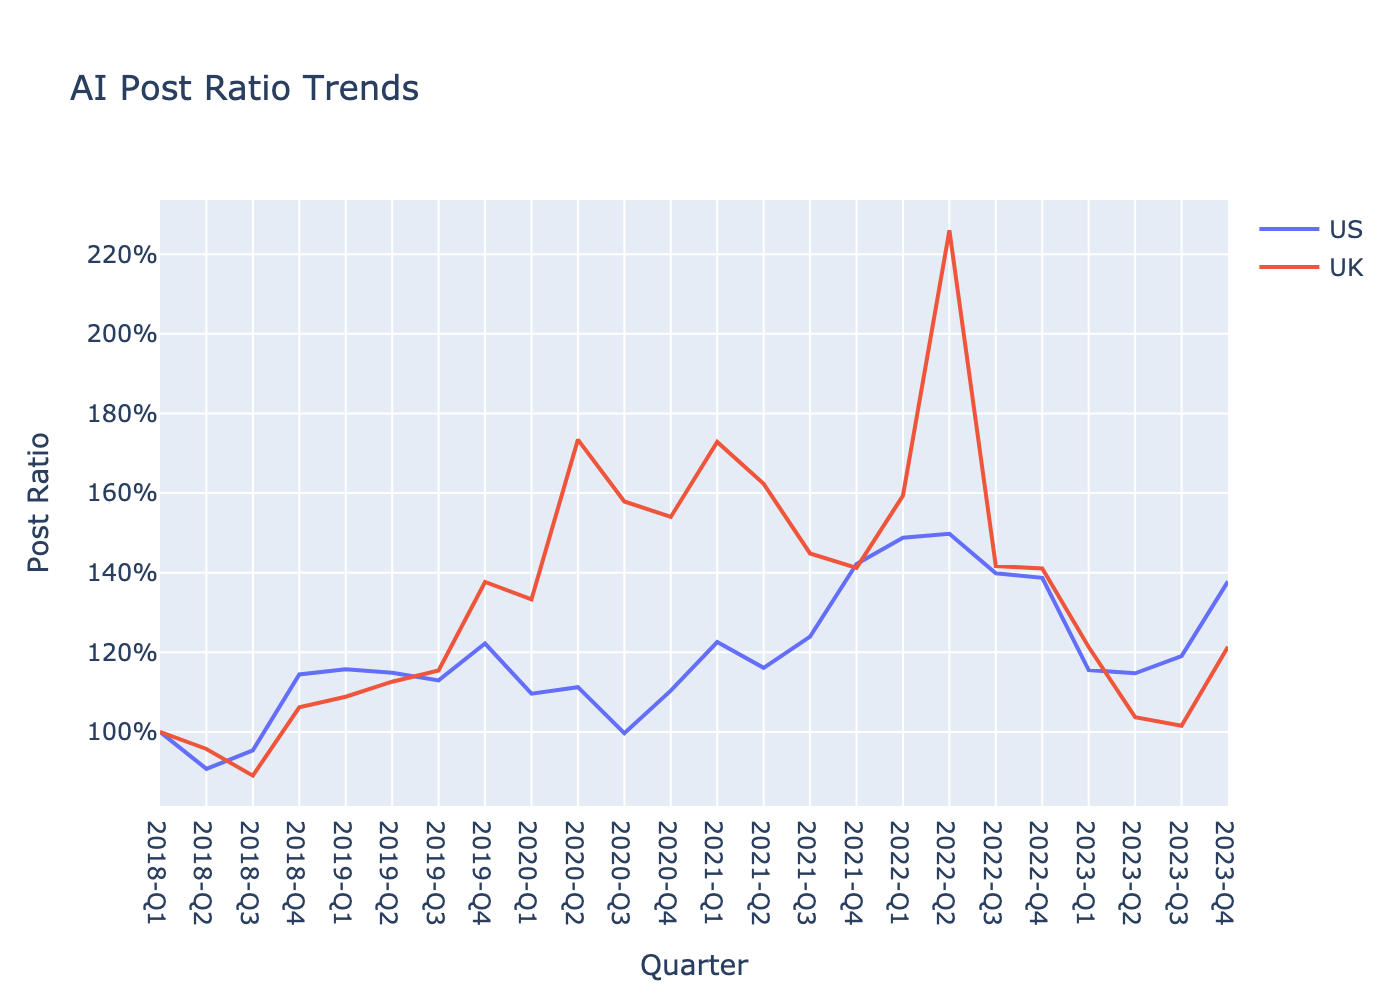

In [4]:
def get_post_ratios(posts_df, skills_df, total_df, skill_list):
    
    post_skill_df = posts_df \
        .join(skills_df, posts_df["ID"] == skills_df["ID"]) \
        .filter(skills_df["SKILL_NAME"].isin(skill_list)) \
        .select(sfunc.year("POSTED").alias("YEAR"), sfunc.quarter("POSTED").alias("QUARTER"), posts_df["ID"]) \
        .group_by(["YEAR", "QUARTER"]) \
        .agg(sfunc.count_distinct(posts_df["ID"]).alias("SKILL_COUNT"))
        
    skill_ratio_df = total_df \
        .join(post_skill_df, ["YEAR", "QUARTER"], "left") \
        .select(sfunc.concat("YEAR", sfunc.concat(sfunc.lit("-Q"), "QUARTER")).alias("QUARTER"), "SKILL_COUNT", "COUNT", (sfunc.col("SKILL_COUNT") / sfunc.col("COUNT")).alias("SKILL_RATIO")) \
        .to_pandas()
    
    skill_ratio_df["SKILL_RATIO"] = skill_ratio_df["SKILL_RATIO"] / skill_ratio_df.loc[skill_ratio_df["QUARTER"] == "2018-Q1", "SKILL_RATIO"].values[0]
    
    return skill_ratio_df

def display_ratios(dataframes, names, title, file_name):
    
    fig = go.Figure()
    
    for i, df in enumerate(dataframes):
        fig.add_trace(go.Scatter(x=df["QUARTER"], y=df["SKILL_RATIO"], mode='lines', name=names[i]))
        
    fig.update_layout(
        title=title, 
        xaxis_title='Quarter', 
        yaxis_title='Post Ratio', 
        width=700, height=500,
        yaxis=dict(tickformat='.0%')
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
    
    display(IPImage(filename=f"figures/{file_name}.png", width=600, height=500))
        

us_ai_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, all_ai_skills)
uk_ai_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, all_ai_skills)
    
# plot ai post ratio trends for us and uk
display_ratios([us_ai_ratio_df, uk_ai_ratio_df], ["US", "UK"], "AI Post Ratio Trends", "figure-1")

### Figure 2

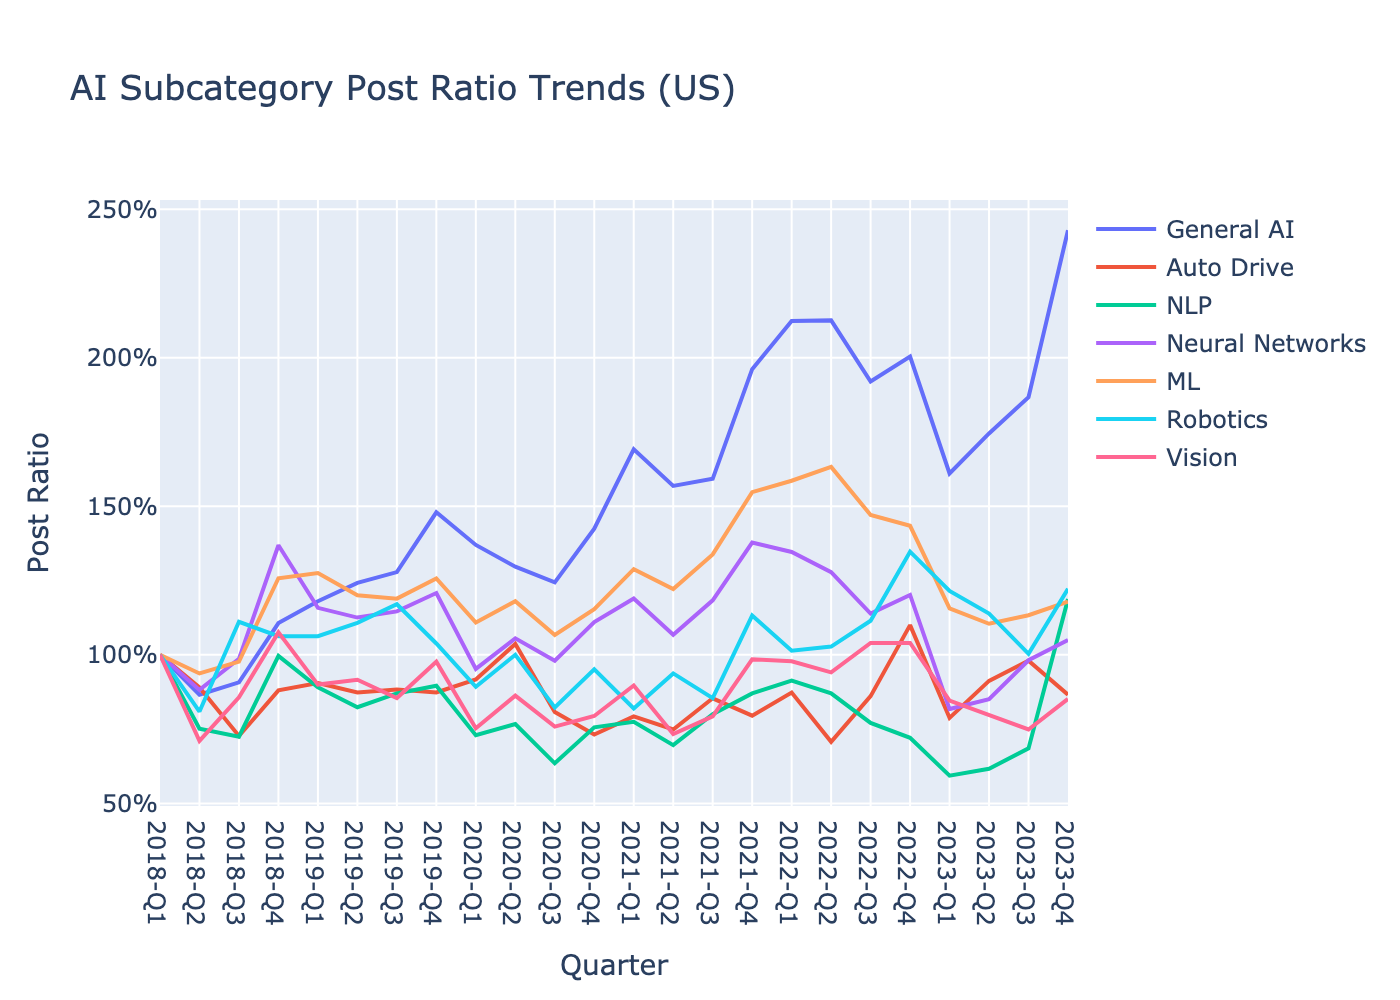

In [5]:
us_genai_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, genai_skills)
us_autodrive_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, auto_drive_skills)
us_nlp_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, nlp_skills)
us_neural_network_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, neural_network_skills)
us_ml_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, ml_skills)
us_robotics_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, robotics_skills)
us_vision_ratio_df = get_post_ratios(us_posts_df, us_skills_df, us_total_posts_df, vision_skills)

# plot ai subcategory post ratio trends for us
display_ratios(
    [us_genai_ratio_df, us_autodrive_ratio_df, us_nlp_ratio_df, us_neural_network_ratio_df, us_ml_ratio_df, us_robotics_ratio_df, us_vision_ratio_df], 
    ["General AI", "Auto Drive", "NLP", "Neural Networks", "ML", "Robotics", "Vision"], 
    "AI Subcategory Post Ratio Trends (US)", 
    "figure-2a"
)

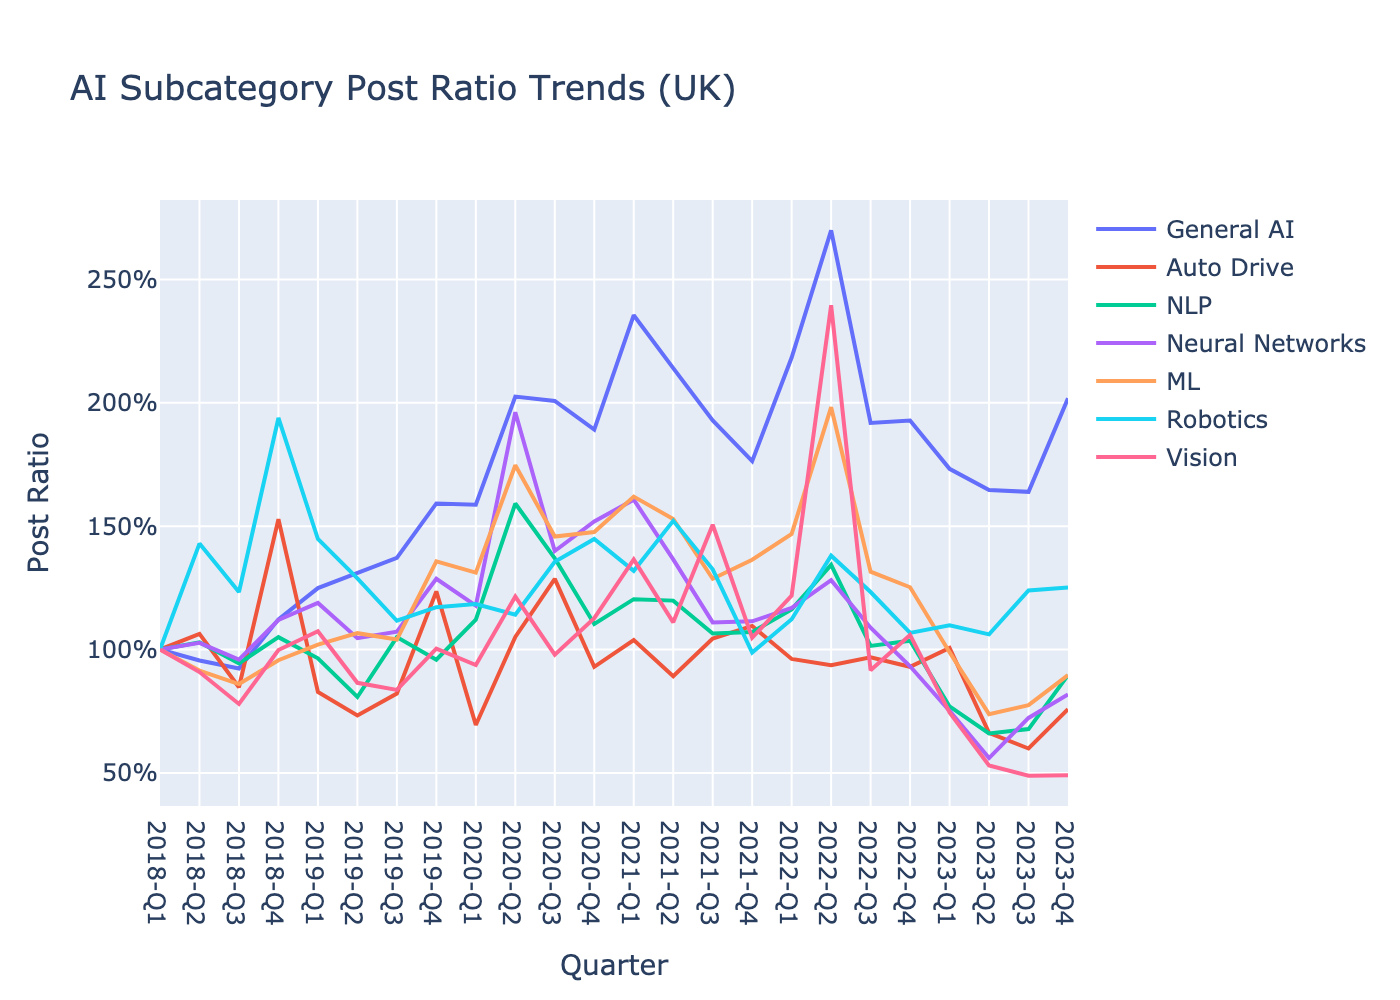

In [6]:
uk_genai_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, genai_skills)
uk_autodrive_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, auto_drive_skills)
uk_nlp_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, nlp_skills)
uk_neural_network_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, neural_network_skills)
uk_ml_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, ml_skills)
uk_robotics_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, robotics_skills)
uk_vision_ratio_df = get_post_ratios(uk_posts_df, uk_skills_df, uk_total_posts_df, vision_skills)

display_ratios(
    [uk_genai_ratio_df, uk_autodrive_ratio_df, uk_nlp_ratio_df, uk_neural_network_ratio_df, uk_ml_ratio_df, uk_robotics_ratio_df, uk_vision_ratio_df], 
    ["General AI", "Auto Drive", "NLP", "Neural Networks", "ML", "Robotics", "Vision"], 
    "AI Subcategory Post Ratio Trends (UK)", 
    "figure-2b"
)

### Figure 3

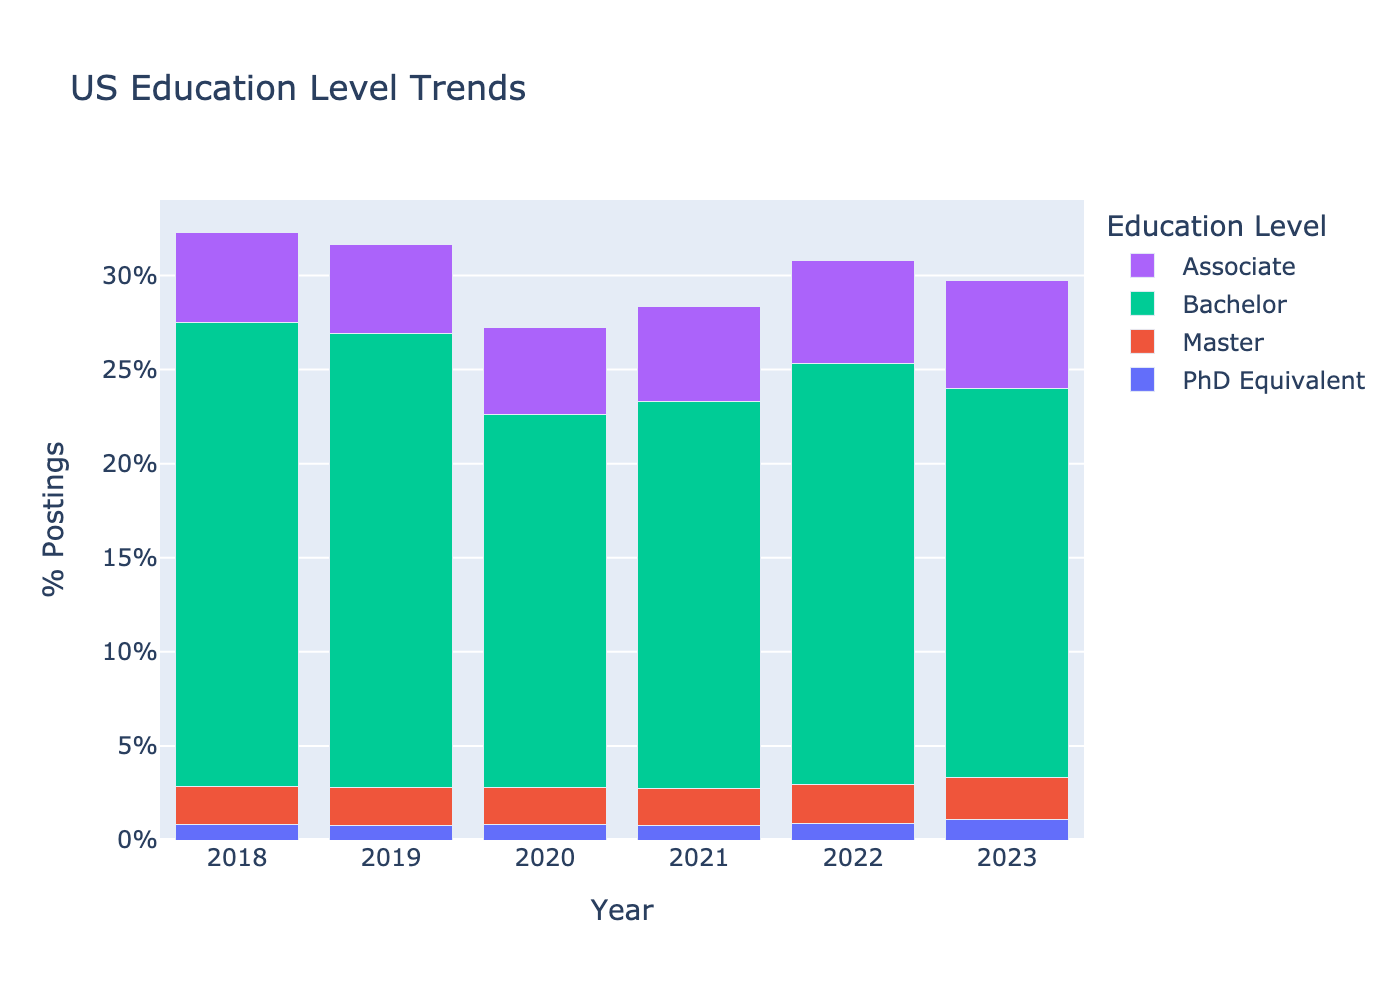

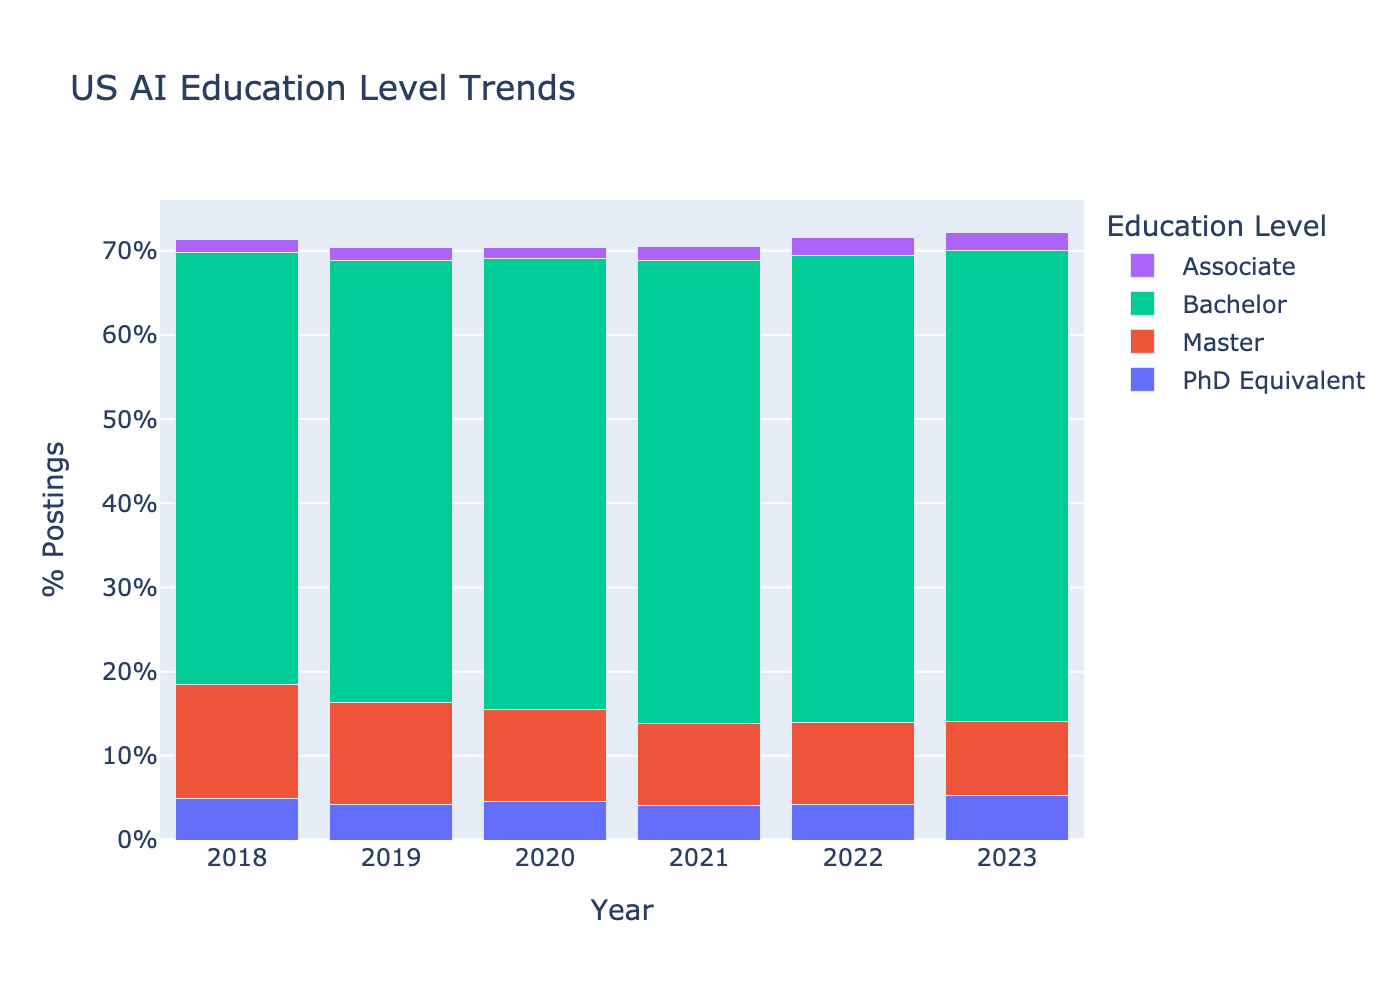

In [53]:
us_nonai_educ_df = us_nonai_posts_df \
    .join(us_skills_df, us_nonai_posts_df["ID"] == us_skills_df["ID"]) \
    .select(sfunc.year("POSTED").alias("YEAR"), us_nonai_posts_df["MIN_EDULEVELS_NAME"], us_nonai_posts_df["ID"]) \
    .group_by(["YEAR", "MIN_EDULEVELS_NAME"]) \
    .agg(sfunc.count_distinct(us_nonai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "MIN_EDULEVELS_NAME", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()

us_ai_educ_df = us_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), us_ai_posts_df["MIN_EDULEVELS_NAME"], us_ai_posts_df["ID"]) \
    .group_by(["YEAR", "MIN_EDULEVELS_NAME"]) \
    .agg(sfunc.count_distinct(us_ai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "MIN_EDULEVELS_NAME", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()
    
us_pivot_df = us_nonai_educ_df.pivot(index="YEAR", columns="MIN_EDULEVELS_NAME", values="SKILL_COUNT").fillna(0).reset_index()
us_pivot_df.iloc[:, 1:] = us_pivot_df.iloc[:, 1:].div(us_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
us_pivot_df = us_pivot_df[["YEAR", "Ph.D. or professional degree", "Master's degree", "Bachelor's degree", "Associate degree"]]
us_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "Associate"]

us_ai_pivot_df = us_ai_educ_df.pivot(index="YEAR", columns="MIN_EDULEVELS_NAME", values="SKILL_COUNT").fillna(0).reset_index()
us_ai_pivot_df.iloc[:, 1:] = us_ai_pivot_df.iloc[:, 1:].div(us_ai_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
us_ai_pivot_df = us_ai_pivot_df[["YEAR", "Ph.D. or professional degree", "Master's degree", "Bachelor's degree", "Associate degree"]]
us_ai_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "Associate"]

def display_education(df, title, file_name):
    
    fig = go.Figure()
    
    for education_level in df.columns[1:]:
        fig.add_trace(go.Bar(
            x=df["YEAR"],
            y=df[education_level],
            name=education_level
        ))

    fig.update_layout(
        barmode='stack',
        title=title,
        xaxis_title='Year',
        yaxis_title='% Postings',
        legend_title='Education Level',
        width=700, height=500,
        yaxis=dict(tickformat='.0%')
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
    
display_education(us_pivot_df, "US Education Level Trends", "figure-3a")
display_education(us_ai_pivot_df, "US AI Education Level Trends", "figure-3b")

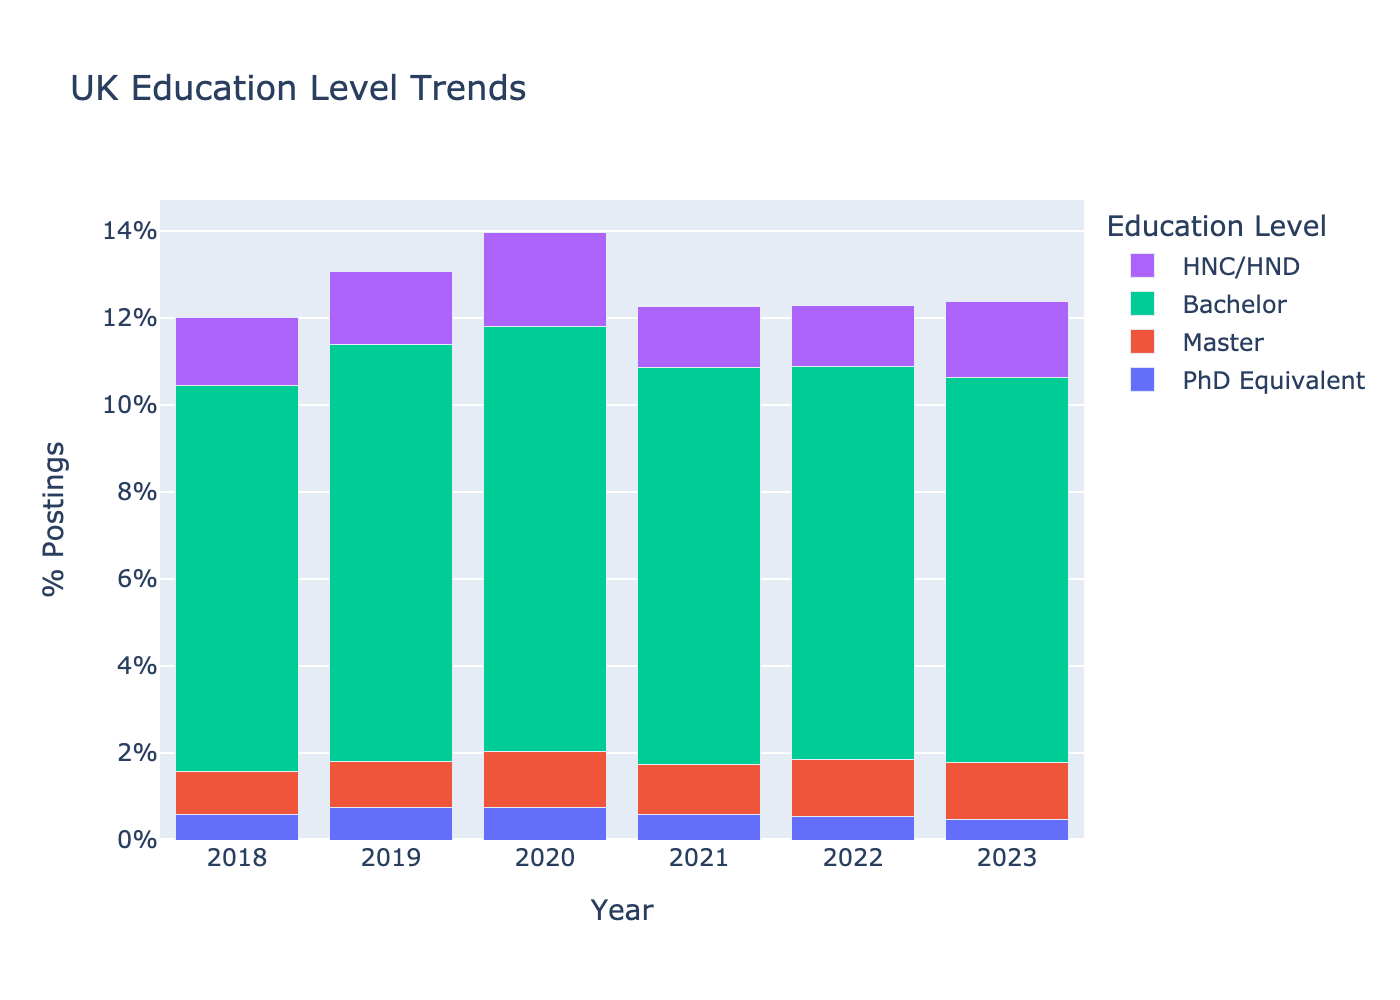

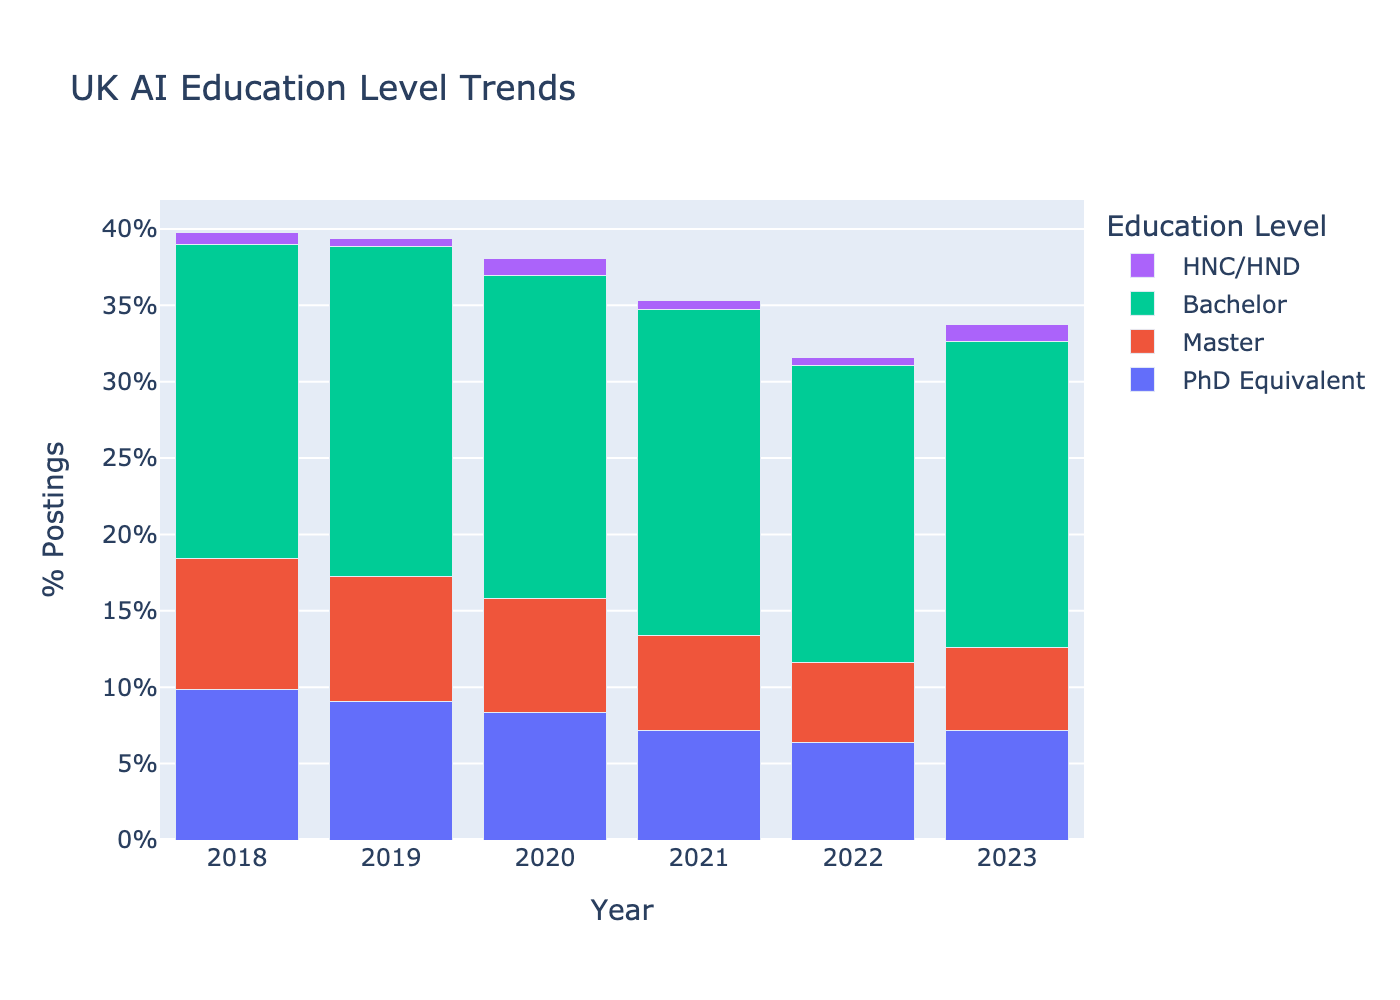

In [73]:
uk_nonai_educ_df = uk_nonai_posts_df \
    .join(uk_skills_df, uk_nonai_posts_df["ID"] == uk_skills_df["ID"]) \
    .select(sfunc.year("POSTED").alias("YEAR"), uk_nonai_posts_df["EDULEVELS_NAME_MIN"], uk_nonai_posts_df["ID"]) \
    .group_by(["YEAR", "EDULEVELS_NAME_MIN"]) \
    .agg(sfunc.count_distinct(uk_nonai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "EDULEVELS_NAME_MIN", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_ai_educ_df = uk_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), uk_ai_posts_df["EDULEVELS_NAME_MIN"], uk_ai_posts_df["ID"]) \
    .group_by(["YEAR", "EDULEVELS_NAME_MIN"]) \
    .agg(sfunc.count_distinct(uk_ai_posts_df["ID"]).alias("SKILL_COUNT")) \
    .select("YEAR", "EDULEVELS_NAME_MIN", sfunc.cast("SKILL_COUNT", stypes.FloatType()).alias("SKILL_COUNT")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_pivot_df = uk_nonai_educ_df.pivot(index="YEAR", columns="EDULEVELS_NAME_MIN", values="SKILL_COUNT").fillna(0).reset_index()
uk_pivot_df.iloc[:, 1:] = uk_pivot_df.iloc[:, 1:].div(uk_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
uk_pivot_df = uk_pivot_df[["YEAR", "Ph.D. or equivalent", "Master's or equivalent", "Bachelor's or equivalent", "Foundation/HNC/HND or equivalent"]]
uk_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "HNC/HND"]

uk_ai_pivot_df = uk_ai_educ_df.pivot(index="YEAR", columns="EDULEVELS_NAME_MIN", values="SKILL_COUNT").fillna(0).reset_index()
uk_ai_pivot_df.iloc[:, 1:] = uk_ai_pivot_df.iloc[:, 1:].div(uk_ai_pivot_df.iloc[:, 1:].sum(axis=1), axis=0)
uk_ai_pivot_df = uk_ai_pivot_df[["YEAR", "Ph.D. or equivalent", "Master's or equivalent", "Bachelor's or equivalent", "Foundation/HNC/HND or equivalent"]]
uk_ai_pivot_df.columns = ["YEAR", "PhD Equivalent", "Master", "Bachelor", "HNC/HND"]

display_education(uk_pivot_df, "UK Education Level Trends", "figure-3c")
display_education(uk_ai_pivot_df, "UK AI Education Level Trends", "figure-3d")

### Figure 4

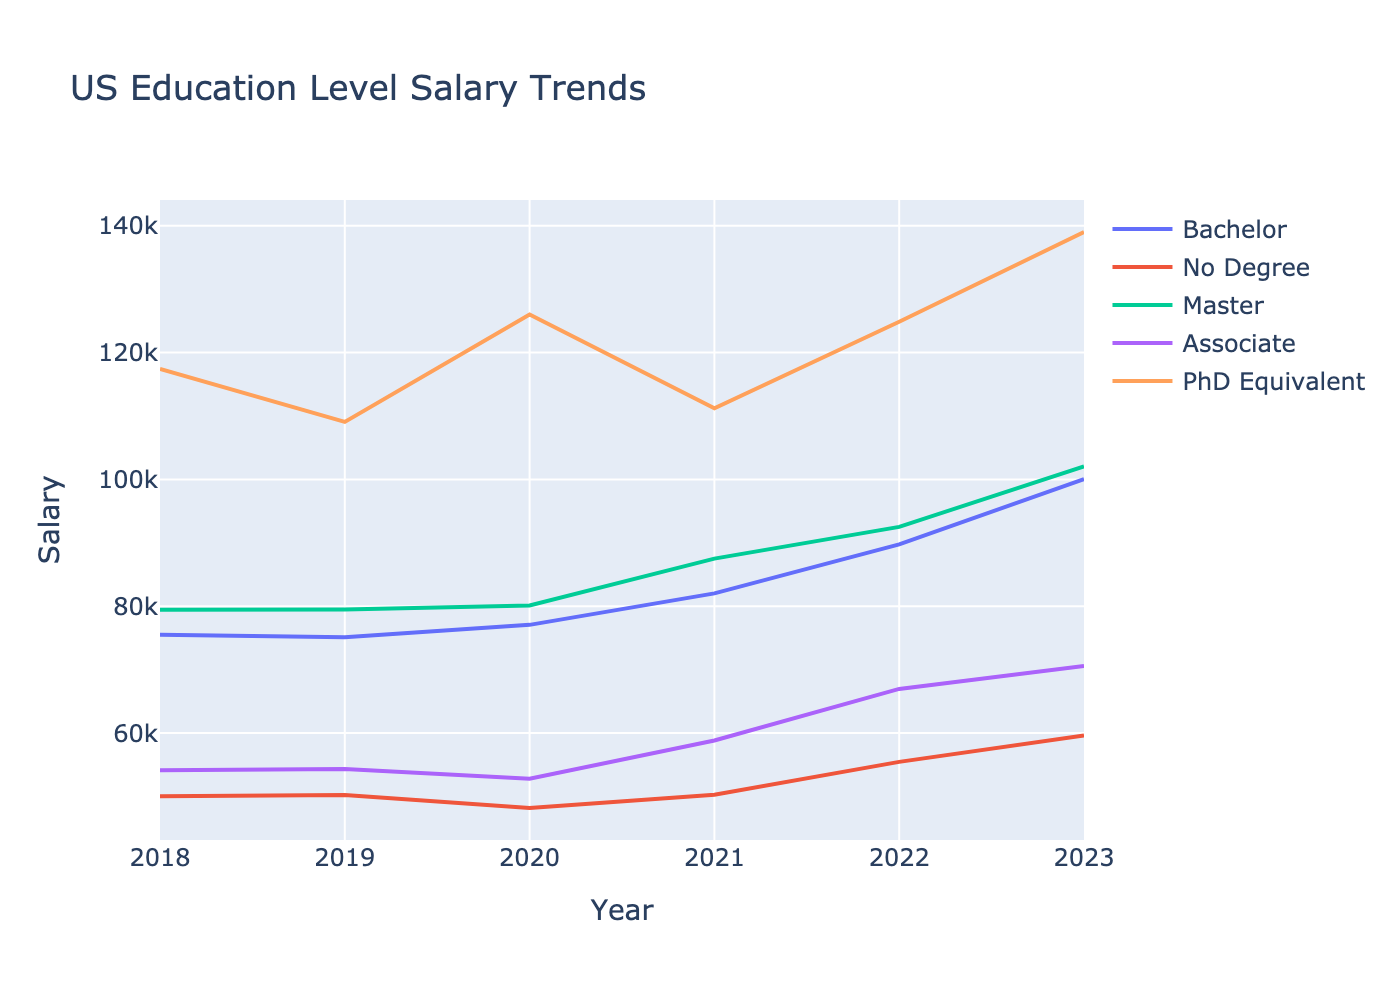

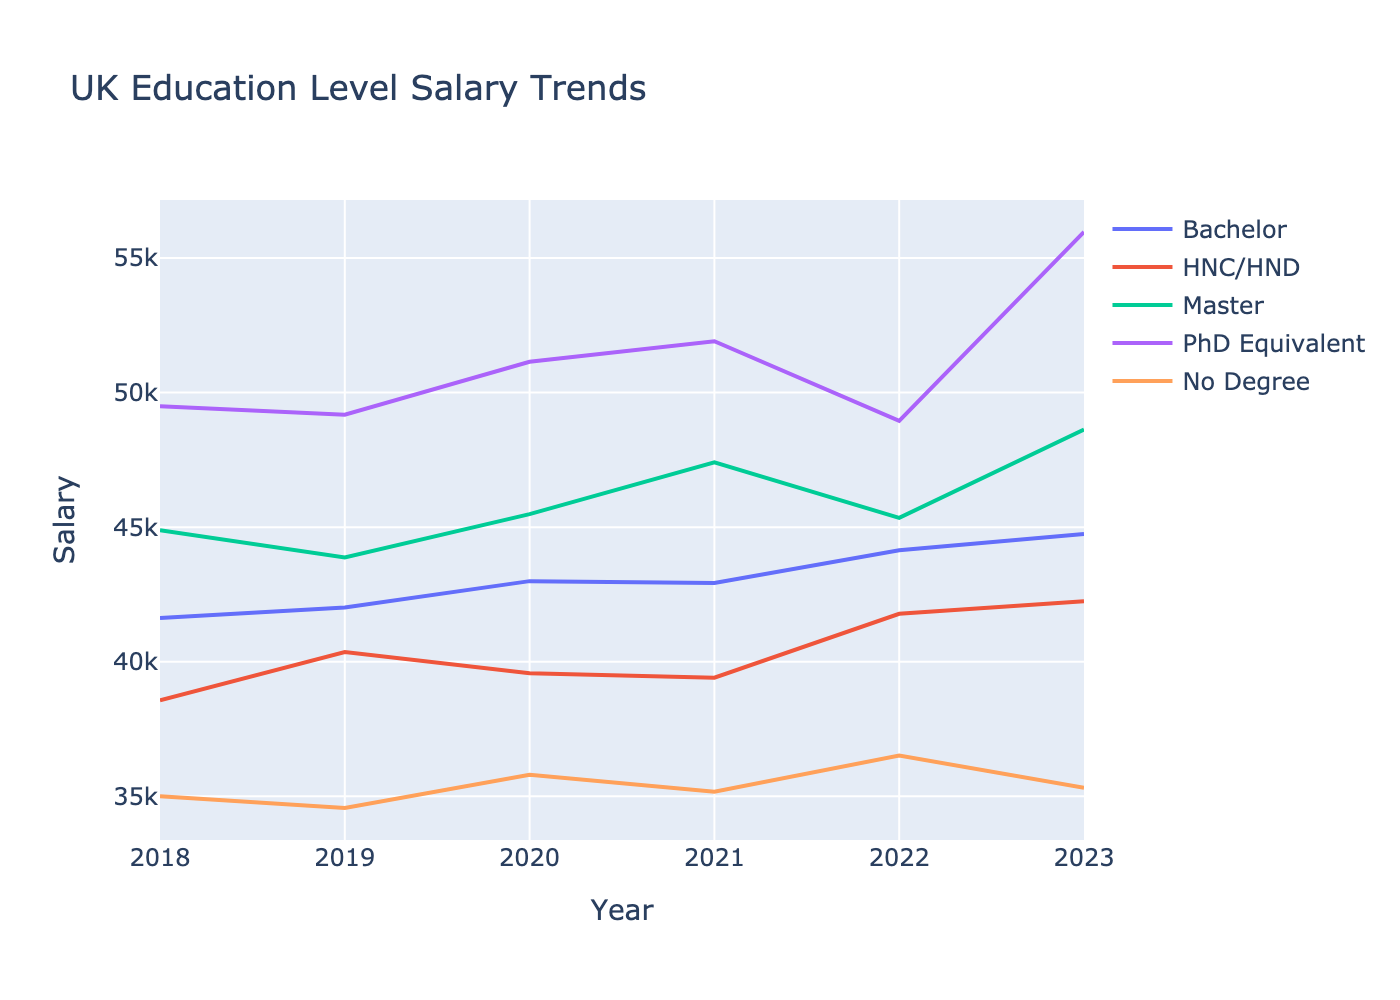

In [76]:
us_educ_wage_df = us_posts_df.with_column(
        "MIN_EDULEVELS_NAME",
        sfunc.when(sfunc.col("MIN_EDULEVELS_NAME") == "No Education Listed", "No Degree")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "High school or GED", "No Degree")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Associate degree", "Associate")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Bachelor's degree", "Bachelor")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Master's degree", "Master")
        .when(sfunc.col("MIN_EDULEVELS_NAME") == "Ph.D. or professional degree", "PhD Equivalent")
        .otherwise(sfunc.col("MIN_EDULEVELS_NAME"))  # Fallback to the original value if not in the map
    ) \
    .select(sfunc.year("POSTED").alias("YEAR"), us_posts_df["MIN_EDULEVELS_NAME"].alias("EDUCATION"), "SALARY") \
    .group_by(["YEAR", "EDUCATION"]) \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_educ_wage_df = uk_posts_df.with_column(
        "EDULEVELS_NAME_MIN",
        sfunc.when(sfunc.col("EDULEVELS_NAME_MIN") == "No Education Listed", "No Degree")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "A-levels or equivalent", "No Degree")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Up to GCSEs or equivalent", "No Degree")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Foundation/HNC/HND or equivalent", "HNC/HND")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Bachelor's or equivalent", "Bachelor")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Master's or equivalent", "Master")
        .when(sfunc.col("EDULEVELS_NAME_MIN") == "Ph.D. or equivalent", "PhD Equivalent")
        .otherwise(sfunc.col("EDULEVELS_NAME_MIN"))  # Fallback to the original value if not in the map
    ) \
    .select(sfunc.year("POSTED").alias("YEAR"), uk_posts_df["EDULEVELS_NAME_MIN"].alias("EDUCATION"), "SALARY") \
    .group_by(["YEAR", "EDUCATION"]) \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()

def display_educ_wages(df, title, file_name):
    
    fig = go.Figure()
    
    education_levels = df["EDUCATION"].unique()   
    
    for education_level in education_levels:
        fig.add_trace(go.Scatter(x=df[df["EDUCATION"] == education_level]["YEAR"], y=df[df["EDUCATION"] == education_level]["SALARY"], mode='lines', name=education_level))
        
    fig.update_layout(
        title=title,
        xaxis_title='Year',
        yaxis_title='Salary',
        width=700, height=500
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))

display_educ_wages(us_educ_wage_df, "US Education Level Salary Trends", "figure-4a")
display_educ_wages(uk_educ_wage_df, "UK Education Level Salary Trends", "figure-4b")

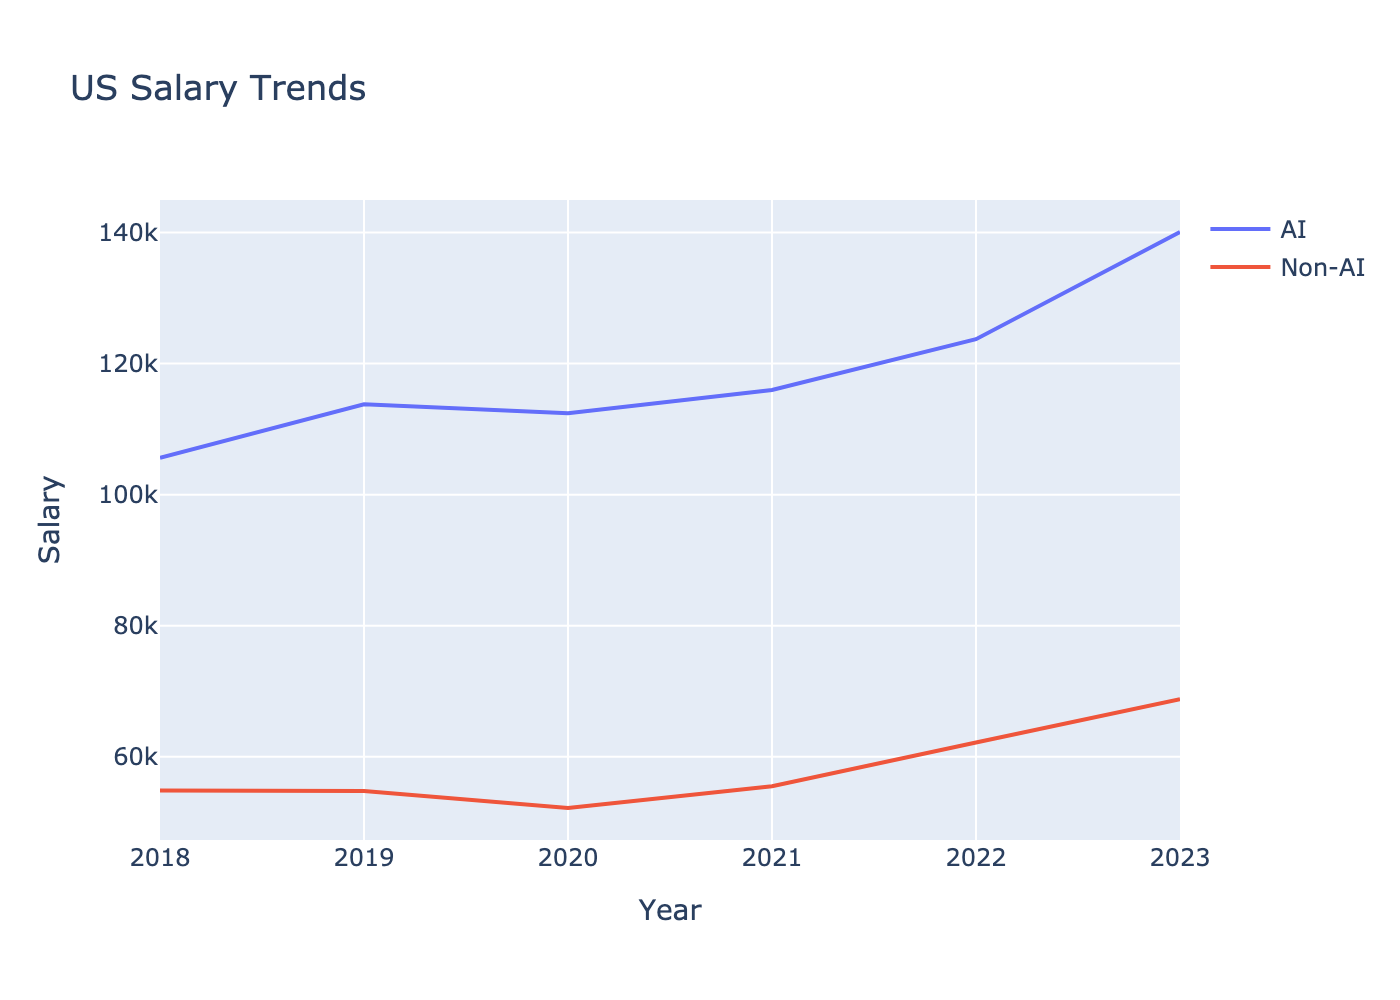

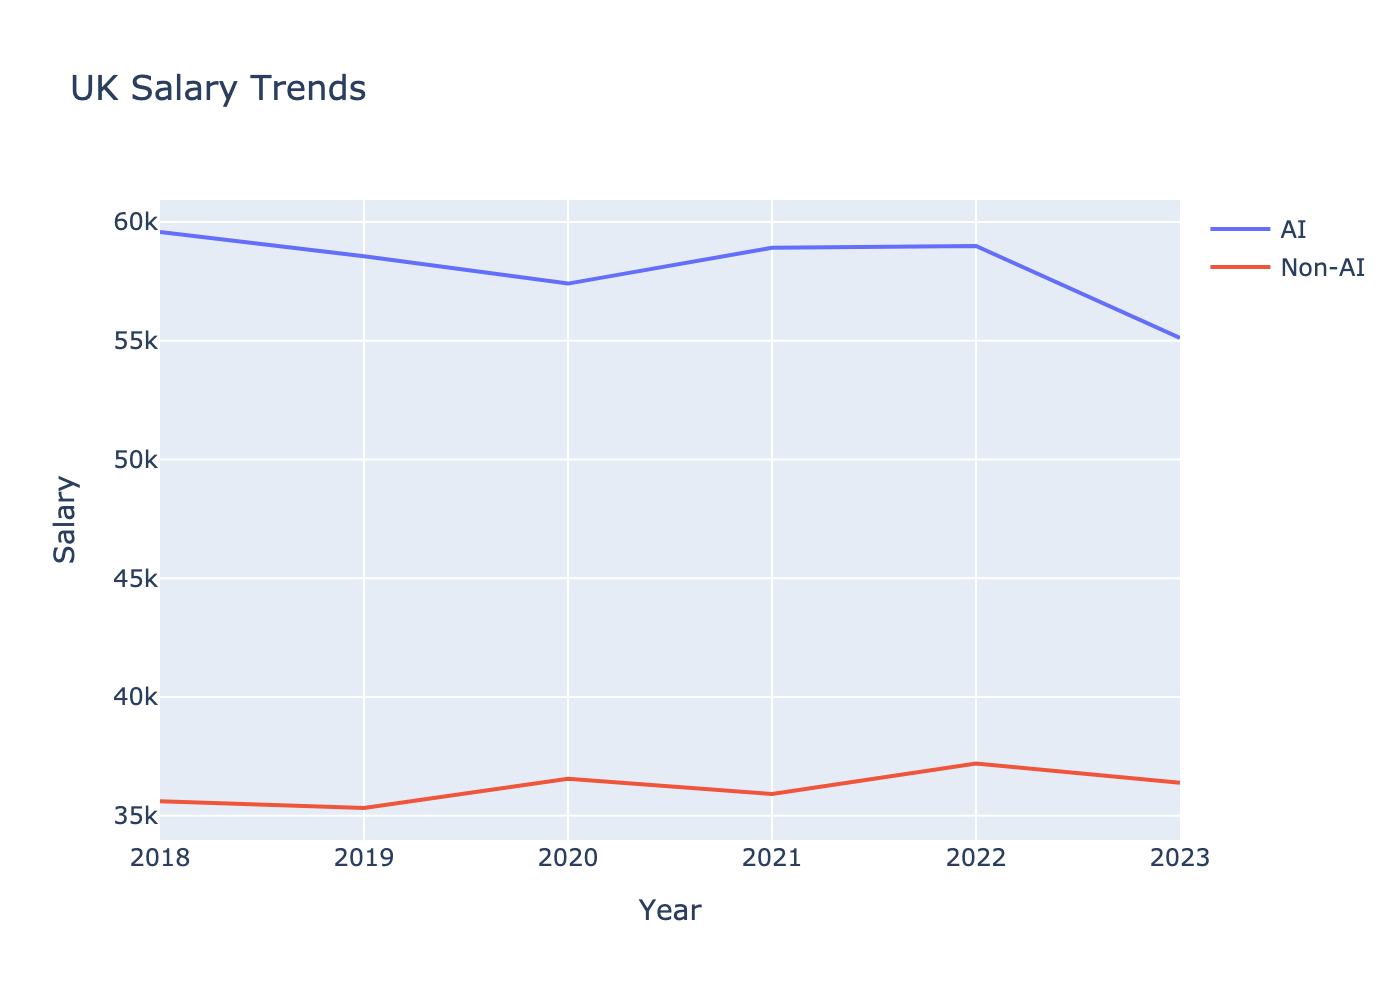

In [82]:
us_ai_wage_df = us_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()

us_nonai_wage_df = us_nonai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_ai_wage_df = uk_ai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
uk_nonai_wage_df = uk_nonai_posts_df \
    .select(sfunc.year("POSTED").alias("YEAR"), "SALARY") \
    .group_by("YEAR") \
    .agg(sfunc.avg("SALARY").alias("SALARY")) \
    .order_by("YEAR") \
    .to_pandas()
    
def display_wages(dataframes, names, title, file_name):
    
    fig = go.Figure()
    
    for i, df in enumerate(dataframes):
        fig.add_trace(go.Scatter(x=df["YEAR"], y=df["SALARY"], mode='lines', name=names[i]))
        
    fig.update_layout(
        title=title,
        xaxis_title='Year',
        yaxis_title='Salary',
        width=700, height=500
    )
    
    with open(f"figures/{file_name}.png", "wb") as f:
        f.write(fig.to_image(format="png", engine="kaleido", scale=2))
        
    display(IPImage(filename=f"figures/{file_name}.png", width=700, height=500))
    
display_wages([us_ai_wage_df, us_nonai_wage_df], ["AI", "Non-AI"], "US Salary Trends", "figure-4c")
display_wages([uk_ai_wage_df, uk_nonai_wage_df], ["AI", "Non-AI"], "UK Salary Trends", "figure-4d")